In [1]:
!pip install prophet

In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import warnings
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric, add_changepoints_to_plot
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import GradientBoostingRegressor


warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Task 1. Forecasting demand by ml***

> Додати блок цитати



In [4]:
# Loading data

orders = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/orders.csv")
order_items = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/order_items.csv")
products = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/products.csv")

In [5]:
# Let's merge tables: products (with id's and params of product)  and order_items (with order_id)

data = order_items.merge(products, how="inner", on="product_id")

So, what demand delay for each category?

In [6]:
#get all categories

data_categories = data["product_category_name"].unique()

# let's create function to compare demands in each category

def cat_compare(data):
  """
  This is function show delay of order-to-order of each categories and show mean
  order time to demand
  Args:
  data - dataset

  Return compare_data - dictionary with category name and time (minutes)
  """
  compare_data = {}
  for column_name in data_categories:
    # filter dataset`s column by category name
    data_test_time = data[data["product_category_name"]==column_name] \
                                        .sort_values("order_purchase_timestamp")
    # add column with diff = delay from order to order
    data_test_time["diff"] = data_test_time["order_purchase_timestamp"].diff()
    # dropping first row
    data_test_time.dropna(inplace=True)
    # some orders contain different qnty, so calc it
    qty = len(data_test_time) + data_test_time["order_item_id"].value_counts().sum()
    # summing all delay
    delay_purchase_time = data_test_time["diff"].sum()
    # calc average time in minutes
    average_purchase_time = delay_purchase_time.total_seconds()/qty/60
    # add result to dictionary
    compare_data[column_name] = average_purchase_time
  return compare_data


In [7]:
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0


In [8]:
# Now we can add order timestamp to table by order_id

data = data.merge(orders, how="inner", on="order_id")

In [9]:
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,28.0,9.0,14.0,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,28.0,9.0,14.0,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,28.0,9.0,14.0,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,...,28.0,9.0,14.0,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,...,28.0,9.0,14.0,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00


In [10]:
data.columns.tolist()

['order_id',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [11]:
# delete unnecessary columns from dataset

data = data.drop(columns=["order_id","product_id", "seller_id",
                          "shipping_limit_date", "customer_id", "order_status",
                          "order_approved_at", "order_delivered_carrier_date",
                          "order_delivered_customer_date",
                          "order_estimated_delivery_date"]).copy()

In [12]:
data.head()

,order_item_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase_timestamp
0,1,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-09-13 08:59:02
1,1,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-06-28 11:52:20
2,1,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2018-05-18 10:25:53
3,1,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-08-01 18:38:42
4,1,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-08-10 21:48:40


In [13]:
# Now we can explore data in dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_item_id               112650 non-null  int64  
 1   price                       112650 non-null  float64
 2   freight_value               112650 non-null  float64
 3   product_category_name       111047 non-null  object 
 4   product_name_lenght         111047 non-null  float64
 5   product_description_lenght  111047 non-null  float64
 6   product_photos_qty          111047 non-null  float64
 7   product_weight_g            112632 non-null  float64
 8   product_length_cm           112632 non-null  float64
 9   product_height_cm           112632 non-null  float64
 10  product_width_cm            112632 non-null  float64
 11  order_purchase_timestamp    112650 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 10.3+ MB


In [14]:
# Converting timestamp column to pandas datetime object

data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_item_id               112650 non-null  int64         
 1   price                       112650 non-null  float64       
 2   freight_value               112650 non-null  float64       
 3   product_category_name       111047 non-null  object        
 4   product_name_lenght         111047 non-null  float64       
 5   product_description_lenght  111047 non-null  float64       
 6   product_photos_qty          111047 non-null  float64       
 7   product_weight_g            112632 non-null  float64       
 8   product_length_cm           112632 non-null  float64       
 9   product_height_cm           112632 non-null  float64       
 10  product_width_cm            112632 non-null  float64       
 11  order_purchase_timestamp    112650 non-

In [15]:
# Check for "na" values

pd.isna(data).sum()

order_item_id                    0
price                            0
freight_value                    0
product_category_name         1603
product_name_lenght           1603
product_description_lenght    1603
product_photos_qty            1603
product_weight_g                18
product_length_cm               18
product_height_cm               18
product_width_cm                18
order_purchase_timestamp         0
dtype: int64

In [16]:
# As na values very small part - we drop it

data.dropna(inplace=True)

In [17]:
# Create table with mean time to sell per 1 item in each category
mean_sell_time = cat_compare(data)

# convert dict to dataframe
mean_sell_time = pd.DataFrame(list(mean_sell_time.items()), columns=['Category', 'Time delay for sell'])

# sorting by ascending time
df_sorted = mean_sell_time.sort_values(by='Time delay for sell', ascending=True)

# check table
df_sorted.head()

,Category,Time delay for sell
10,cama_mesa_banho,44.889216
7,beleza_saude,53.099691
11,esporte_lazer,57.893851
2,moveis_decoracao,62.472152
18,informatica_acessorios,63.856277


# ***A bit of feature engeneering***

In [18]:
# As we know many type of categories can sell seasonally, so i create column "month" and "day of week"

data["order_purchase_month"] = data["order_purchase_timestamp"].dt.month
data["purchase_day_of_week"] = data["order_purchase_timestamp"].dt.day_of_week

with library holidays i'll add is holiday to dataset

In [19]:
import holidays
br_holidays = holidays.Brazil(years=[2016,2017,2018])
print(list(br_holidays)[:5])
list_holidays = list(br_holidays)

[datetime.date(2016, 1, 1), datetime.date(2016, 3, 25), datetime.date(2016, 4, 21), datetime.date(2016, 5, 1), datetime.date(2016, 9, 7)]


now for check dates in holidays list, i define function , that converts date_time to datetime.date

In [20]:
import datetime

# Function convertation to datetime.date
def convert_to_date(date_str):
    return datetime.datetime.strptime(str(date_str), '%Y-%m-%d %H:%M:%S').date()

In [21]:
# check convert date function
print(convert_to_date(data.loc[5,"order_purchase_timestamp"]))

2017-07-27


In [22]:
# Create dataset with column is_hollyday
data_holidays = data
data_holidays["is_hollyday"] = data_holidays["order_purchase_timestamp"].apply(
                  lambda x:1 if convert_to_date(x) in list_holidays else 0)

In [23]:
data_holidays[data_holidays["is_hollyday"] == 1].head()

,order_item_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase_timestamp,order_purchase_month,purchase_day_of_week,is_hollyday
158,1,89.9,11.24,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,2017-05-01 20:29:52,5,0,1
180,1,89.9,16.26,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,2017-11-02 17:38:40,11,3,1
184,1,89.9,11.24,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,2017-05-01 20:33:42,5,0,1
206,2,86.9,3.38,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,2018-01-01 22:40:31,1,0,1
207,1,48.0,33.82,cama_mesa_banho,42.0,431.0,1.0,850.0,40.0,6.0,50.0,2018-01-01 22:40:31,1,0,1


Adding column is weekend.

In [24]:
data_ft_days = data_holidays
data_ft_days["is_weekend"] = data_ft_days["purchase_day_of_week"].apply(
                            lambda x: 1 if x >5 else 0)
data_ft_days.head(7)

,order_item_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase_timestamp,order_purchase_month,purchase_day_of_week,is_hollyday,is_weekend
0,1,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-09-13 08:59:02,9,2,0,0
1,1,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-06-28 11:52:20,6,2,0,0
2,1,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2018-05-18 10:25:53,5,4,0,0
3,1,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-08-01 18:38:42,8,1,0,0
4,1,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-08-10 21:48:40,8,3,0,0
5,1,55.9,26.93,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-07-27 15:11:51,7,3,0,0
6,1,64.9,38.50,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2018-03-18 21:00:44,3,6,0,1


And convert categorical data to integers by "get_dummies"

In [25]:
dummies_data = pd.get_dummies(data_ft_days, prefix="product_category_name",
                              dtype="int")
dummies_data.head()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,1,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,...,0,0,0,0,0,0,0,0,0,0
1,1,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,...,0,0,0,0,0,0,0,0,0,0
2,1,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,...,0,0,0,0,0,0,0,0,0,0
3,1,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,...,0,0,0,0,0,0,0,0,0,0
4,1,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,...,0,0,0,0,0,0,0,0,0,0


and now we can remove unnecessary columns

In [26]:
data.columns

Index(['order_item_id', 'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'order_purchase_timestamp',
       'order_purchase_month', 'purchase_day_of_week', 'is_hollyday',
       'is_weekend'],
      dtype='object')

i think that dependece by columns weight lenght height width with freight value high so, i'drop them








In [27]:
cor_columns_list = ['product_weight_g','product_length_cm','product_height_cm',
                                'product_width_cm', "order_purchase_timestamp"]
dummies_data.drop(columns=cor_columns_list, inplace=True)

In [28]:
dummies_data.head()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,order_purchase_month,purchase_day_of_week,is_hollyday,is_weekend,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,1,58.9,13.29,58.0,598.0,4.0,9,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55.9,17.96,58.0,598.0,4.0,6,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,64.9,18.33,58.0,598.0,4.0,5,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,58.9,16.17,58.0,598.0,4.0,8,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,58.9,13.29,58.0,598.0,4.0,8,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#Define features
X = dummies_data.drop(columns="order_item_id")
#Define target
y = dummies_data["order_item_id"]

#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,
                                                    shuffle=True)


In [31]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

xgb = GradientBoostingRegressor(**params)

xgb.fit(X_train, y_train)

mae = mae (y_test, xgb.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 0.3156


In [32]:
predicted_column = xgb.predict(X)

In [33]:
predicted_data = data_ft_days
predicted_data["predict_demend"] = predicted_column

In [49]:
predicted_data[["order_item_id", "predict_demend"]].tail(20)

,order_item_id,predict_demend
112630,1,1.305688
112631,1,1.178923
112632,1,1.084543
112633,1,1.132298
112634,1,1.442321
112635,2,1.442321
112636,3,1.442321
112637,1,1.148047
112638,1,1.146526
112639,1,1.164735


# ***Forecasting by PROPHET***

In [20]:
# Forecasting model accuracy evaluation
# model evaluation

# model evaluation


def evaluate_forecasting_model(actual_values:pd.Series,
                          predicted_values:pd.Series, round_nbr:int=2) -> None:
    mape = mean_absolute_percentage_error(
        actual_values,
        predicted_values
    )
    mae = mean_absolute_error(
        actual_values,
        predicted_values
    )
    mse = mean_squared_error(
        actual_values,
        predicted_values
    )

    print(f"MAE - {round(mae, round_nbr)}")
    print(f"MSE - {round(mse, round_nbr)}")
    print(f"MAPE - {round(mape, round_nbr)}")

In [21]:
data["product_category_name"].unique()

array(['cool_stuff', 'pet_shop', 'moveis_decoracao', 'perfumaria',
       'ferramentas_jardim', 'utilidades_domesticas', 'telefonia',
       'beleza_saude', 'livros_tecnicos', 'bebes',
       'fashion_bolsas_e_acessorios', 'cama_mesa_banho', 'casa_conforto',
       'alimentos', 'relogios_presentes', 'casa_construcao',
       'esporte_lazer', 'consoles_games', 'pc_gamer', 'moveis_escritorio',
       'malas_acessorios', 'agro_industria_e_comercio', 'papelaria',
       'eletronicos', 'informatica_acessorios',
       'construcao_ferramentas_construcao', 'moveis_sala', 'audio',
       'construcao_ferramentas_iluminacao', 'brinquedos', 'moveis_quarto',
       'industria_comercio_e_negocios', 'automotivo',
       'moveis_cozinha_area_de_servico_jantar_e_jardim', 'climatizacao',
       'eletrodomesticos', 'telefonia_fixa',
       'portateis_casa_forno_e_cafe', 'artes', 'fraldas_higiene',
       'sinalizacao_e_seguranca', 'instrumentos_musicais',
       'eletroportateis', 'construcao_ferramenta

In [22]:
# lets explore category "cool_stuff" sorting by time

cool_stuff_data = data[data["product_category_name"]== "cool_stuff"].sort_values("order_purchase_timestamp").reset_index()

# define just necessary features

cool_stuff_data = cool_stuff_data[["order_purchase_timestamp","order_item_id"]]

# change columns names as need model prophet

cool_stuff_data.columns = ['ds', 'y']
cool_stuff_data["ds"] = cool_stuff_data["ds"].dt.floor('D')

# getting quantity of sells by day
cool_stuff_data = cool_stuff_data.groupby("ds").sum().reset_index()

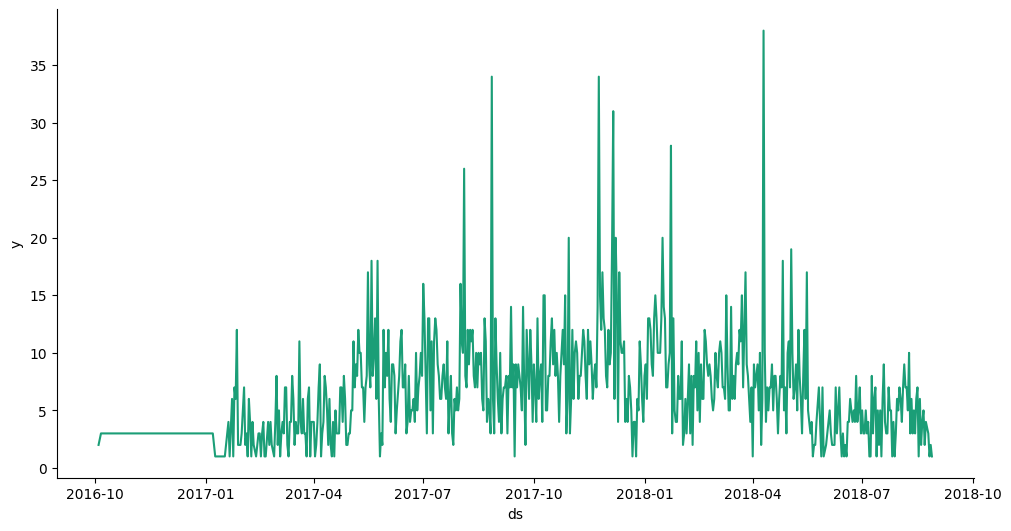

In [23]:
# @title ds vs y


def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cool_stuff_data.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

As we see, dataset has anomalies, and we can delete them by deleting values more then 15


In [24]:
# let`s observe data

cool_stuff_data["y"].describe()

count    584.000000
mean       6.981164
std        4.631682
min        1.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       38.000000
Name: y, dtype: float64

In [25]:
# to avoid nozzle from anomaly i'll remove all cells per day greater or equal 15

cool_stuff_data = cool_stuff_data[cool_stuff_data["y"]<=15]

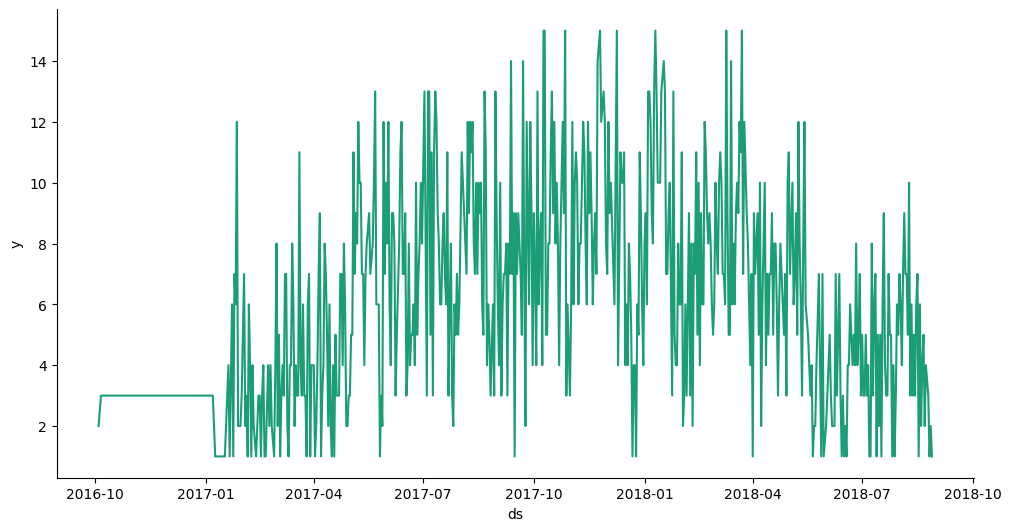

In [26]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cool_stuff_data.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

Now it looks greater

In [27]:
print("num of rows where sells per day equal 1 -----", len(cool_stuff_data[cool_stuff_data["y"] == 1]))
print("num of rows where sells per day more then 1 -----", len(cool_stuff_data[cool_stuff_data["y"] > 1]))

num of rows where sells per day equal 1 ----- 42
num of rows where sells per day more then 1 ----- 521


we have imbalanced data

In [28]:
# split dataframe on train and test
window = round(len(cool_stuff_data)/30)
train, test = cool_stuff_data[:-window], cool_stuff_data[-window:]

In [69]:
# Train model

model_prophet = Prophet()

model_prophet.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/ifs5z33l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/u4zdx_z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98350', 'data', 'file=/tmp/tmp6udn_e3s/ifs5z33l.json', 'init=/tmp/tmp6udn_e3s/u4zdx_z_.json', 'output', 'file=/tmp/tmp6udn_e3s/prophet_modelhga_l0h4/prophet_model-20240507064454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [71]:
# Create Future dates
future_sales = model_prophet.make_future_dataframe(periods=30)

# Predict sales
forecast = model_prophet.predict(future_sales)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2016-10-04,2.794824,-0.781436,6.308583
1,2016-10-06,3.601378,-0.162467,7.019036
2,2016-10-07,2.017996,-1.355842,5.508879
3,2017-01-07,5.126265,1.703719,8.461849
4,2017-01-09,5.303823,1.921904,8.655478


In [31]:
# display components
plot_components_plotly(model_prophet, forecast, figsize=(1000, 300))

In [32]:
plot = plot_plotly(model_prophet, forecast, figsize=(1400, 700))
plot.update_layout(showlegend=True)

In [33]:

# merge test set with forecasted values
benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")

# Plot actual and forecasted data
fig = px.line(benchmark_df, x='ds', y=["y", "yhat"], markers=True, title="Prophet forecast")
# Show plot
fig.show()

In [34]:
# evaluate forecasting using Mean Absolute Percentage Error (MAPE)
evaluate_forecasting_model(
    actual_values=benchmark_df['y'],
    predicted_values=benchmark_df['yhat'],
    round_nbr=3
)

MAE - 1.813
MSE - 4.86
MAPE - 0.822


14 days

In [35]:
# to compare and calculate loss i define test set from "not cleaned data"

test_data_column = data[data["product_category_name"]== "cool_stuff"].sort_values("order_purchase_timestamp").reset_index()

test_data_column = test_data_column[["order_purchase_timestamp","order_item_id"]]

test_data_column.columns = ['ds', 'y']
test_data_column["ds"] = test_data_column["ds"].dt.floor('D')

# getting quantity of sells by day
test_data_column = test_data_column.groupby("ds").sum().reset_index()


In [36]:
# Train and forecast model for next 14 days

window = 14
train, test = cool_stuff_data[:-window], test_data_column[-window:]
model_prophet = Prophet()
model_prophet.fit(train)
# Create Future dates
future_sales = model_prophet.make_future_dataframe(periods=15)

# Predict sales
forecast = model_prophet.predict(future_sales)
# merge test set with forecasted values
benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")
benchmark_df["yhat"] = round(benchmark_df["yhat"])

# Plot actual and forecasted data
fig = px.line(benchmark_df, x='ds', y=["y", "yhat"], markers=True, title="Prophet forecast")
# Show plot
fig.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/az42ry8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/jfscdtde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7839', 'data', 'file=/tmp/tmp6udn_e3s/az42ry8e.json', 'init=/tmp/tmp6udn_e3s/jfscdtde.json', 'output', 'file=/tmp/tmp6udn_e3s/prophet_modelalo_f1e5/prophet_model-20240507063234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
print(benchmark_df['y'].sum())
print(benchmark_df['yhat'].sum())
accuracy = benchmark_df['y'].sum() / benchmark_df['yhat'].sum() * 100
print("точність за 14 днів % =  ", accuracy,"%")

47
61.0
точність за 14 днів % =   77.04918032786885 %


In [38]:
benchmark_df.dropna(inplace=True)

In [39]:
# evaluate forecasting using Mean Absolute Percentage Error (MAPE)
evaluate_forecasting_model(
    actual_values=benchmark_df['y'],
    predicted_values=benchmark_df['yhat'],
    round_nbr=3
)

MAE - 1.714
MSE - 4.0
MAPE - 0.961


# ***Improving accuracy by OPTUNA***

Ass we see here. accuracy not very well. Let's improve it

Prophet + LGBM. I got samples from medium : [improving prophet accuracy](https://medium.com/@andrey.chubin.95/improving-facebook-prophet-forecasts-with-lightgbm-and-optuna-5710b2b5ce80#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImFjM2UzZTU1ODExMWM3YzdhNzVjNWI2NTEzNGQyMmY2M2VlMDA2ZDAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTQyOTk2MDMxMDE3NjI1MjA2NzgiLCJlbWFpbCI6Inh4eHNlcmd4eHg2MkBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmJmIjoxNzE0NzE3ODMwLCJuYW1lIjoiU2VyaGlpIEtvbG90dWtoaW4iLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUNnOG9jTHJkeks3WHJENWpLVGNtNEVtLUJ1U0E4aDdoeVVLb0pUS25yQ29Ua3lReTlNRERBPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IlNlcmhpaSIsImZhbWlseV9uYW1lIjoiS29sb3R1a2hpbiIsImlhdCI6MTcxNDcxODEzMCwiZXhwIjoxNzE0NzIxNzMwLCJqdGkiOiI4ZWY0MzcxMTc3N2ZhYTI5YWQxODMxNTc5Y2EyZjdkOWZjYzA0YTA1In0.jb6ms9IeHDAfcpXvRvX8yx-YrN8i5zQ_IMLP3KLdOz1cH8ccnBlI9FRecIO1WCtePITV0kp2BFtQPIJM80YAgPgNJMGVZA2XWmIAmD9B7XTErhx53F976t71wpQSYmgJXDRe1vKN3j2la2BY9glBYgmcWY6zuJCKaqGuJp5mKabOCMp-bvjU1AvxoQK4-8t3x17ZdXBr_jmg6buWqemIpxIkLFQUyL-3ZwO7Pd8YVAC62rbwv9rNJ2Ilwx97XQcZqbFrZI5KDghGqcvqtkqFkeaSEDrHLoXeWSTr2gBSDPVEfYTGRQbO-7gXa2Ncx0CGiMpTSZHbRmU4RFnC1L_4rQ)

In [40]:
!pip install optuna
!pip install optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 2.7 MB/s eta 0:00:00


In [41]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import Dataset
import pandas as pd
import numpy as np
import os
import sys

import re
from typing import Optional
from itertools import product
from tqdm import tqdm
from holidays.holiday_base import HolidayBase
from prophet import Prophet
from contextlib import contextmanager



class OptunaLGBMRegressor:
    """
    A wrapper class for the LightGBM Regressor with Optuna for hyperparameters tuning
    """

    def __init__(
        self,
        n_estimators: int,
        learning_rate: float = 0.01,
        metric: str = 'rmse',
        cat_columns: str = 'auto',
        seed: int = 42
    ):
        """
        Initializes a new instance of the OptunaLGBMRegressor class
        """
        self.params = {
            "n_estimators": n_estimators,
            "objective": "regression",
            "verbosity": -1,
            "metric": metric,
            "learning_rate": learning_rate,
            "boosting_type": 'gbdt',
            "random_state": seed
        }
        self.cat_columns = cat_columns
        self.model = None
        self.features = None
        self.is_fitted_ = False

    def _to_datasets(
        self, x_train: pd.DataFrame, y_train: np.ndarray, x_val: pd.DataFrame, y_val: np.ndarray
    ) -> (Dataset, Dataset):
        """
        Converts Pandas DataFrames to LightGBM Datasets
        """
        self.features = list(x_train.columns)
        X_val = x_val[self.features].copy()
        dtrain = Dataset(x_train, label=y_train, categorical_feature=self.cat_columns)
        dval = Dataset(X_val, label=y_val, categorical_feature=self.cat_columns)

        return dtrain, dval

    def fit(self, X_train: pd.DataFrame, y_train: np.ndarray, X_val: pd.DataFrame, y_val: np.ndarray) -> None:
        dtrain, dval = self._to_datasets(X_train, y_train, X_val, y_val)

        params = {
          "objective": "binary",
          "metric": "binary_logloss",
          "verbosity": -1,
          "boosting_type": "gbdt",
        }

        self.model = lgb.train(
            params,
            dtrain,
            valid_sets=[dtrain, dval],
            # verbose_eval=0,
            # early_stopping_rounds=150
        )

        self.is_fitted_ = True

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        assert self.is_fitted_, 'Model is not fitted!'
        return self.model.predict(X_test[self.features], num_iteration=self.model.best_iteration)

In [42]:


@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


class ProphetsEnsemble:
    """An ensemble of Prophet models with different aggregation functions and frequencies."""

    def __init__(self, freq: str, levels: list, agg_fn: list, holidays_getter: HolidayBase = None):
        """Initializes an ensemble of Prophet models."""
        self.freq = freq
        self.levels = ['_'.join(x) for x in product(levels, agg_fn)]
        self.h_getter = holidays_getter
        self.prophets_ = dict()
        self.is_fitted_ = False

    @staticmethod
    def _resample(data: pd.DataFrame, freq: str, how: str) -> pd.DataFrame:
        """Resamples a time series DataFrame."""
        if how not in ['median', 'mean', 'sum']:
            raise NotImplementedError(f'Unknown function {how}. Only [median, mean, sum] are supported.')
        return data.set_index('ds').resample(freq).agg(how).reset_index(drop=False)

    @staticmethod
    def _merge_key_gen(x, level: str) -> str:
        """Generates a key for merging DataFrames based on the frequency."""
        freq = re.sub('[\d]', '', level.split('_')[0])
        if freq == 'H':
            return f'{x.year}-{x.month}-{x.day}-{x.hour}'
        elif freq in ['D', 'M']:
            return f'{x.year}-{x.month}-{x.day}' if freq == 'D' else f'{x.year}-{x.month}'
        elif freq == 'W':
            return f'{x.isocalendar().year}-{x.isocalendar().week}'
        raise NotImplementedError(f'Only [H, D, W, M] are supported. {freq} was recieved as input!')

    def _get_holidays(self, data: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Extracts holidays from the data."""
        if self.h_getter is None:
            return None
        holidays = data[['ds']].copy()
        holidays['holiday'] = holidays['ds'].apply(self.h_getter.get)
        return holidays.dropna()

    def _fit_level(self, data: pd.DataFrame, level: str) -> None:
        """Fits a Prophet model for a specific aggregation level."""
        resampled = self._resample(data, *level.split('_')) if level != self.freq else data.copy()
        fb = Prophet(holidays=self._get_holidays(resampled))
        with suppress_stdout_stderr():
            fb.fit(resampled)
        self.prophets_[level] = fb

    def _predict_level(self, periods: int, level: str) -> pd.DataFrame:
        """Makes predictions for a specific aggregation level."""
        fb = self.prophets_[level]
        df = fb.make_future_dataframe(periods=periods, freq=level.split('_')[0])
        forecasts = fb.predict(df)
        forecasts.columns = [f'{x}_{level}' for x in forecasts.columns]
        return forecasts

    def _combine_levels(self, base_df: pd.DataFrame, data: pd.DataFrame, level: str) -> pd.DataFrame:
        """Combines predictions from different aggregation levels."""
        key = lambda x: self._merge_key_gen(x, level)
        return (
            base_df.assign(key=base_df['ds'].apply(key))
            .merge(data.assign(key=data[f'ds_{level}'].apply(key)), on='key', how='left')
            .drop(['key', f'ds_{level}'], axis=1)
        )

    @staticmethod
    def _drop_redundant(data: pd.DataFrame) -> pd.DataFrame:
        """Drops redundant features from the DataFrame."""
        redundant = [col for col in data.columns if col != 'ds' and 'yhat' not in col and len(data[col].unique()) == 1]
        return data.drop(redundant, axis=1)

    def fit(self, data: pd.DataFrame) -> None:
        """Fits the Prophet models for all aggregation levels."""
        for level in tqdm([self.freq] + self.levels, 'Fitting prophets...'):
            self._fit_level(data, level)
        self.is_fitted_ = True

    def forecast(self, periods: int) -> pd.DataFrame:
        """Makes forecasts for all aggregation levels and combines them."""
        assert self.is_fitted_, 'Model is not fitted'
        forecasts = [self._predict_level(periods, level) for level in tqdm([self.freq] + self.levels, 'Forecasting...')]

        forecast = forecasts[0].rename(columns={f'ds_{self.freq}': 'ds'})
        for level, fore in zip(self.levels, forecasts[1:]):
            forecast = self._combine_levels(forecast, fore, level)

        return self._drop_redundant(forecast)

In [43]:
# Train and forecast model for next 14 days

window = 14
train, test = cool_stuff_data[:-window], test_data_column[-window:]
model_prophet = Prophet()
model_prophet.fit(train)
# Create Future dates
future_sales = model_prophet.make_future_dataframe(periods=15)

# Predict sales
forecast = model_prophet.predict(future_sales)
# merge test set with forecasted values
benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")
benchmark_df["yhat"] = round(benchmark_df["yhat"])



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/qeynqu2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/93aksfot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87019', 'data', 'file=/tmp/tmp6udn_e3s/qeynqu2q.json', 'init=/tmp/tmp6udn_e3s/93aksfot.json', 'output', 'file=/tmp/tmp6udn_e3s/prophet_modelk0z0frei/prophet_model-20240507063300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [44]:
# Split data by sklearn train_test_split and train model

from sklearn.model_selection import train_test_split


gbt_data = train.merge(forecast, on='ds', how='left')
train_gbt, val_gbt = train_test_split(gbt_data, test_size=0.15, random_state=42)

lgbm = OptunaLGBMRegressor(n_estimators=300, learning_rate=0.03, metric='mape', seed=42)

lgbm.fit(
    train_gbt.drop(['ds', 'y'], axis=1), train_gbt.y.values,
    val_gbt.drop(['ds', 'y'], axis=1), val_gbt.y.values
)

test_gbt = test.merge(forecast, on='ds', how='left')
preds = lgbm.predict(test_gbt.drop(['ds', 'y'], axis=1))

forecast_df = test_gbt[['ds', 'y', 'yhat']].copy()
forecast_df['gbt_yhat'] = preds

[I 2024-05-07 06:33:00,715] A new study created in memory with name: no-name-e8d84c09-6f6f-460a-a28a-a799fa0dd5a8
min_child_samples, val_score: 0.000000: 100%|##########| 5/5 [00:00<00:00, 13.87it/s]


In [45]:
# evaluate forecasting using Mean Absolute Percentage Error (MAPE)
evaluate_forecasting_model(
    actual_values=forecast_df['y'],
    predicted_values=forecast_df['gbt_yhat'],
    round_nbr=3
)

MAE - 2.357
MSE - 9.357
MAPE - 0.547


In [46]:
# Plot actual and forecasted data
fig = px.line(forecast_df, x='ds', y=["y", "gbt_yhat"], markers=True, title="Prophet forecast")
# Show plot
fig.show()

In [47]:
pe = ProphetsEnsemble(freq='D', levels=['W', 'M'], agg_fn=['mean', 'median'])
pe.fit(train)
pe_forecast = pe.forecast(len(test))

gbt_data = train.merge(pe_forecast, on='ds', how='left')
train_gbt, val_gbt = train_test_split(gbt_data, test_size=0.15, random_state=42)

lgbm = OptunaLGBMRegressor(n_estimators=300, learning_rate=0.03, metric='mape', seed=42)

lgbm.fit(
    train_gbt.drop(['ds', 'y'], axis=1), train_gbt.y.values,
    val_gbt.drop(['ds', 'y'], axis=1), val_gbt.y.values
)

test_gbt = test.merge(pe_forecast, on='ds', how='left')
preds = lgbm.predict(test_gbt.drop(['ds', 'y'], axis=1))
forecast_df['pe_yhat'] = preds

Fitting prophets...:   0%|          | 0/5 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/74uaa_lf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/o_6_olwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20005', 'data', 'file=/tmp/tmp6udn_e3s/74uaa_lf.json', 'init=/tmp/tmp6udn_e3s/o_6_olwx.json', 'output', 'file=/tmp/tmp6udn_e3s/prophet_modell1dcu07p/prophet_model-20240507063307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

In [48]:
mean_absolute_percentage_error(forecast_df['y'], forecast_df['pe_yhat'])

0.5469387755102045

In [49]:
# evaluate forecasting using Mean Absolute Percentage Error (MAPE)
evaluate_forecasting_model(
    actual_values=forecast_df['y'],
    predicted_values=forecast_df['pe_yhat'],
    round_nbr=3)

MAE - 2.357
MSE - 9.357
MAPE - 0.547


In [50]:
# Plot actual and forecasted data
fig = px.line(forecast_df, x='ds', y=["y", "pe_yhat"], markers=True, title="Prophet forecast")
# Show plot
fig.show()

# ***Somthing else from OPTUNA***

In [51]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import optuna

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


test_size = int(cool_stuff_data.shape[0] / 10)
train_df = cool_stuff_data.iloc[:-test_size, :]
val_df = cool_stuff_data.iloc[-test_size:int(-test_size/2), :]
test_df = cool_stuff_data.iloc[int(-test_size/2):, :]

In [52]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }

    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(train_df)
    preds = m.predict(val_df['ds'])

    mae_score = mean_absolute_error(val_df['y'], preds['yhat'])
    return mae_score

In [53]:
params = {
     'changepoint_prior_scale': 3.391667952710346,
     'changepoint_range': 0.8397114666270911,
     'seasonality_prior_scale': 3.6115808925351867,
     'holidays_prior_scale': 4.845991897188627,
     'seasonality_mode': 'multiplicative',
     'growth': 'linear',
     'weekly_seasonality': 10,
     'yearly_seasonality': 3
}

In [54]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)

    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }

    return report_dict

In [55]:
test_df.columns

Index(['ds', 'y'], dtype='object')

In [56]:
m = Prophet(**params)

concat_train_df = pd.concat([train_df, val_df])
m.fit(concat_train_df)
preds = m.predict(test_df[['ds']])
result = regression_report(test_df['y'], preds['yhat'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/ck7my41q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/78bidcvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86932', 'data', 'file=/tmp/tmp6udn_e3s/ck7my41q.json', 'init=/tmp/tmp6udn_e3s/78bidcvi.json', 'output', 'file=/tmp/tmp6udn_e3s/prophet_modeli3pkne0d/prophet_model-20240507063348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
result


{'mae_score': 1.813758080943426,
 'mse_score': 5.062346572772879,
 'r2_score': 0.09199732028049956}

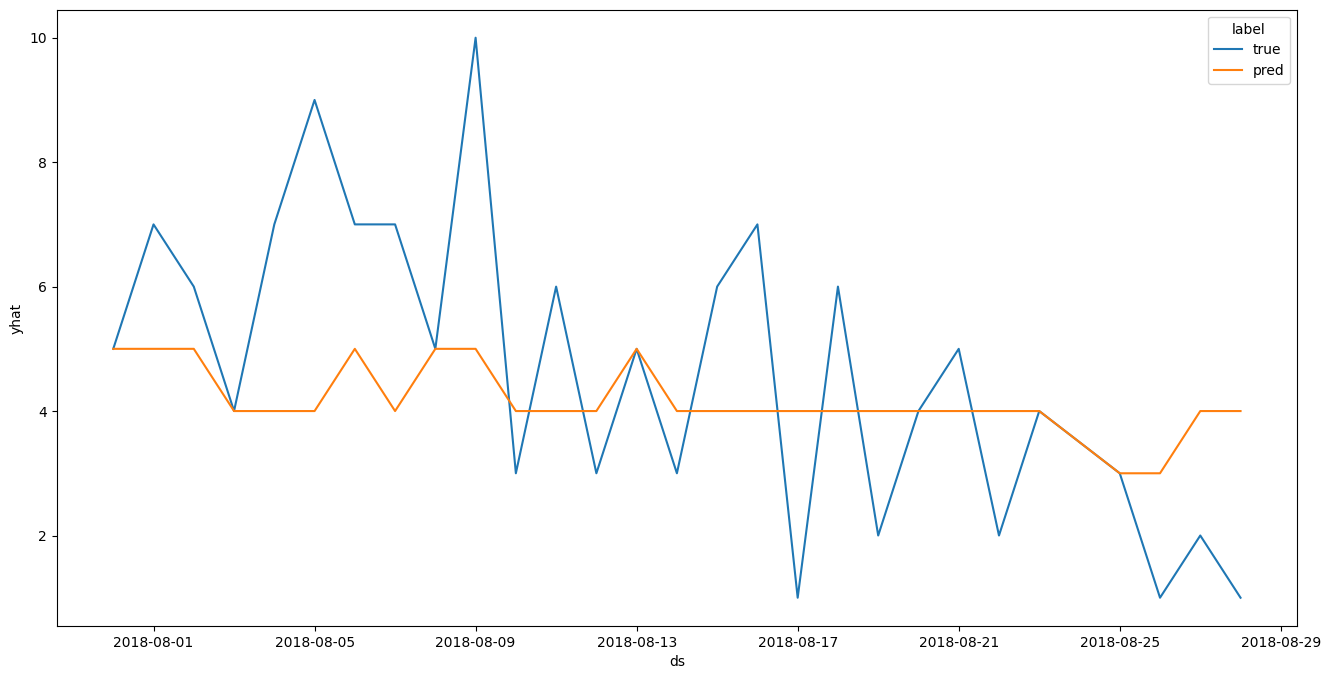

In [58]:
pd.options.mode.chained_assignment = None
test_df.loc[:, 'label'] = 'true'
test_df.loc[:, 'yhat'] = test_df.loc[:, 'y']
preds.loc[:, 'label'] = 'pred'
df_result = pd.concat([test_df[['yhat', 'label', 'ds']], preds[['yhat', 'label', 'ds']]])
df_result['yhat']=round(df_result['yhat'])
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(y='yhat', x='ds', ax=ax, data=df_result, hue='label', markers=True)
plt.show()


# ***Compare conclusion***

In case with just 1 category the best score gave clean Prophet with
MAE - 1.714
MSE - 4.0
MAPE - 0.961
and near 77 % accuracy.
rest tune models show results badly. So i write predict function from my Prophet Template

# Forecasting class by **Prophet** demand for a short-term period (14 days) 7 days after the last date in the data

In [59]:
class DemandForecast:
    def __init__(self, data):
        """
        This class provides functions to predict the demand for a specific
        product category for the next 14 days after last items 7 day operation.

        Args:
        - data: DataFrame containing historical sales data including product
        categories and purchase timestamps.
        """
        self.data = data

    def _evaluate_forecasting_model(self, actual_values, predicted_values, round_nbr=2):
        """
        Evaluate the forecasting model using MAE, MSE, and MAPE.

        Args:
        - actual_values: Actual sales values.
        - predicted_values: Predicted sales values.
        - round_nbr: Number of decimal places to round the metrics to (default=2).
        """
        actual_values = actual_values.fillna(0)
        predicted_values = predicted_values.fillna(0)

        mape = mean_absolute_percentage_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        mse = mean_squared_error(actual_values, predicted_values)

        print(f"MAE - {round(mae, round_nbr)}")
        print(f"MSE - {round(mse, round_nbr)}")
        print(f"MAPE - {round(mape, round_nbr)}")


    def predict_demand(self, category):
        """
        Predict the demand for the entered product category for the next 14 days.

        Args:
        - category: Name of the product category for which demand is to be predicted.

        Returns:
        - Forecasted demand for the next 14 days.
        """
        if category in self.data["product_category_name"].unique():
            warnings.filterwarnings('ignore')

            # Clean and preprocess data
            cool_stuff_data = self.data[self.data["product_category_name"] ==
                                        category]. \
                                        sort_values("order_purchase_timestamp").reset_index()
            cool_stuff_data = cool_stuff_data[["order_purchase_timestamp",
                                               "order_item_id"]]
            cool_stuff_data.columns = ['ds', 'y']
            cool_stuff_data["ds"] = cool_stuff_data["ds"].dt.floor('D')
            cool_stuff_data = cool_stuff_data.groupby("ds").sum().reset_index()

            #To avoid anomalies we can remove all data more then 85 %
            cool_stuff_data = cool_stuff_data[cool_stuff_data["y"] <= 0.85 *
                                              cool_stuff_data["y"].max()]
            cool_stuff_data = cool_stuff_data.dropna()

            # Prepare test set for evaluation
            test_data_column = self.data[self.data["product_category_name"] ==
                                         category]. \
                                         sort_values("order_purchase_timestamp").reset_index()
            test_data_column = test_data_column[["order_purchase_timestamp",
                                                 "order_item_id"]]
            test_data_column.columns = ['ds', 'y']
            test_data_column["ds"] = test_data_column["ds"].dt.floor('D')
            test_data_column = test_data_column.groupby("ds").sum().reset_index()
            window = 14
            train, test = cool_stuff_data[:-window], test_data_column[-window:]

            # Train and forecast model
            model_prophet = Prophet()
            model_prophet.fit(train)

            # Define data with future 14 days of last operation
            future_sales = pd.date_range(start=cool_stuff_data["ds"].max(), periods=21)
            future_sales = pd.DataFrame(future_sales, columns=["ds"])
            future_sales = future_sales.loc[7:,:]

            forecast = np.round(model_prophet.predict(future_sales))

            # Merge test set with forecasted values
            benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")
            benchmark_df["yhat"] = round(benchmark_df["yhat"])

            # Evaluate forecasting using MAPE
            self._evaluate_forecasting_model(actual_values=benchmark_df['y'],
                                             predicted_values=benchmark_df['yhat'])

            return forecast[['ds', 'yhat']].tail(14)
        else:
            raise ValueError("Category not found in the data.")


In [60]:
data["product_category_name"].unique()

array(['cool_stuff', 'pet_shop', 'moveis_decoracao', 'perfumaria',
       'ferramentas_jardim', 'utilidades_domesticas', 'telefonia',
       'beleza_saude', 'livros_tecnicos', 'bebes',
       'fashion_bolsas_e_acessorios', 'cama_mesa_banho', 'casa_conforto',
       'alimentos', 'relogios_presentes', 'casa_construcao',
       'esporte_lazer', 'consoles_games', 'pc_gamer', 'moveis_escritorio',
       'malas_acessorios', 'agro_industria_e_comercio', 'papelaria',
       'eletronicos', 'informatica_acessorios',
       'construcao_ferramentas_construcao', 'moveis_sala', 'audio',
       'construcao_ferramentas_iluminacao', 'brinquedos', 'moveis_quarto',
       'industria_comercio_e_negocios', 'automotivo',
       'moveis_cozinha_area_de_servico_jantar_e_jardim', 'climatizacao',
       'eletrodomesticos', 'telefonia_fixa',
       'portateis_casa_forno_e_cafe', 'artes', 'fraldas_higiene',
       'sinalizacao_e_seguranca', 'instrumentos_musicais',
       'eletroportateis', 'construcao_ferramenta

In [61]:
# Create class
forecast_model = DemandForecast(data)

# Forecasting
category = "moveis_decoracao"
forecast_result = forecast_model.predict_demand(category)


print(forecast_result)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/7evscpyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6udn_e3s/r779_u48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9610', 'data', 'file=/tmp/tmp6udn_e3s/7evscpyc.json', 'init=/tmp/tmp6udn_e3s/r779_u48.json', 'output', 'file=/tmp/tmp6udn_e3s/prophet_modelyuxa0p_i/prophet_model-20240507063350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:33:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE - 16.21
MSE - 474.64
MAPE - 1.0
           ds  yhat
0  2018-09-04  27.0
1  2018-09-05  22.0
2  2018-09-06  26.0
3  2018-09-07  23.0
4  2018-09-08  19.0
5  2018-09-09  21.0
6  2018-09-10  25.0
7  2018-09-11  27.0
8  2018-09-12  22.0
9  2018-09-13  26.0
10 2018-09-14  23.0
11 2018-09-15  19.0
12 2018-09-16  21.0
13 2018-09-17  25.0


# ***Task 1 . Forecasting by classic time series model***

In [62]:
# lets explore category "cool_stuff" sorting by time

cool_stuff_data = data[data["product_category_name"]== "cool_stuff"].sort_values("order_purchase_timestamp").reset_index()

# define just necessary features

cool_stuff_data = cool_stuff_data[["order_purchase_timestamp","order_item_id"]]

# change columns names as need model prophet

cool_stuff_data.columns = ['date', 'value']
cool_stuff_data["date"] = cool_stuff_data["date"].dt.floor('D')

# getting quantity of sells by day
cool_stuff_data = cool_stuff_data.groupby("date").sum().reset_index()


In [63]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Define your ARIMA model
model = ARIMA(cool_stuff_data['value'], order=(1, 1, 2))

# Fit the model
model_fit = model.fit()

# Print the summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  584
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1645.335
Date:                Tue, 07 May 2024   AIC                           3298.670
Time:                        06:33:51   BIC                           3316.143
Sample:                             0   HQIC                          3305.481
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8367      0.088     -9.512      0.000      -1.009      -0.664
ma.L1          0.0117      0.079      0.149      0.882      -0.142       0.166
ma.L2         -0.8029      0.062    -12.871      0.0

In [64]:
# 1,1,1 ARIMA Model
model = ARIMA(cool_stuff_data['value'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  584
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1649.096
Date:                Tue, 07 May 2024   AIC                           3304.192
Time:                        06:33:51   BIC                           3317.297
Sample:                             0   HQIC                          3309.300
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0363      0.043      0.851      0.395      -0.047       0.120
ma.L1         -0.8929      0.022    -40.823      0.000      -0.936      -0.850
sigma2        16.7226      0.399     41.873      0.0

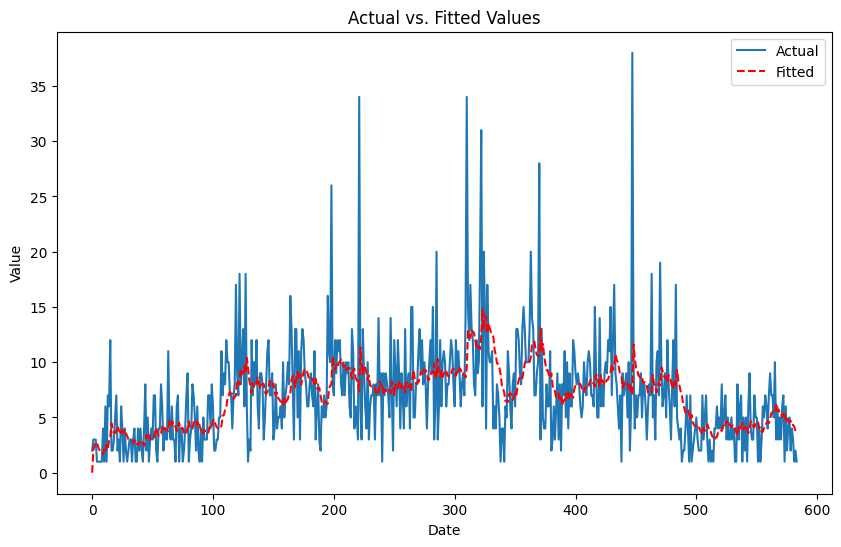

In [65]:
# Plot actual vs. fitted values
plt.figure(figsize=(10, 6))
plt.plot(cool_stuff_data.index, cool_stuff_data['value'], label='Actual')
plt.plot(cool_stuff_data.index, model_fit.fittedvalues, color='red', linestyle='--', label='Fitted')
plt.title('Actual vs. Fitted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# ***Task conclusion***

Prophet

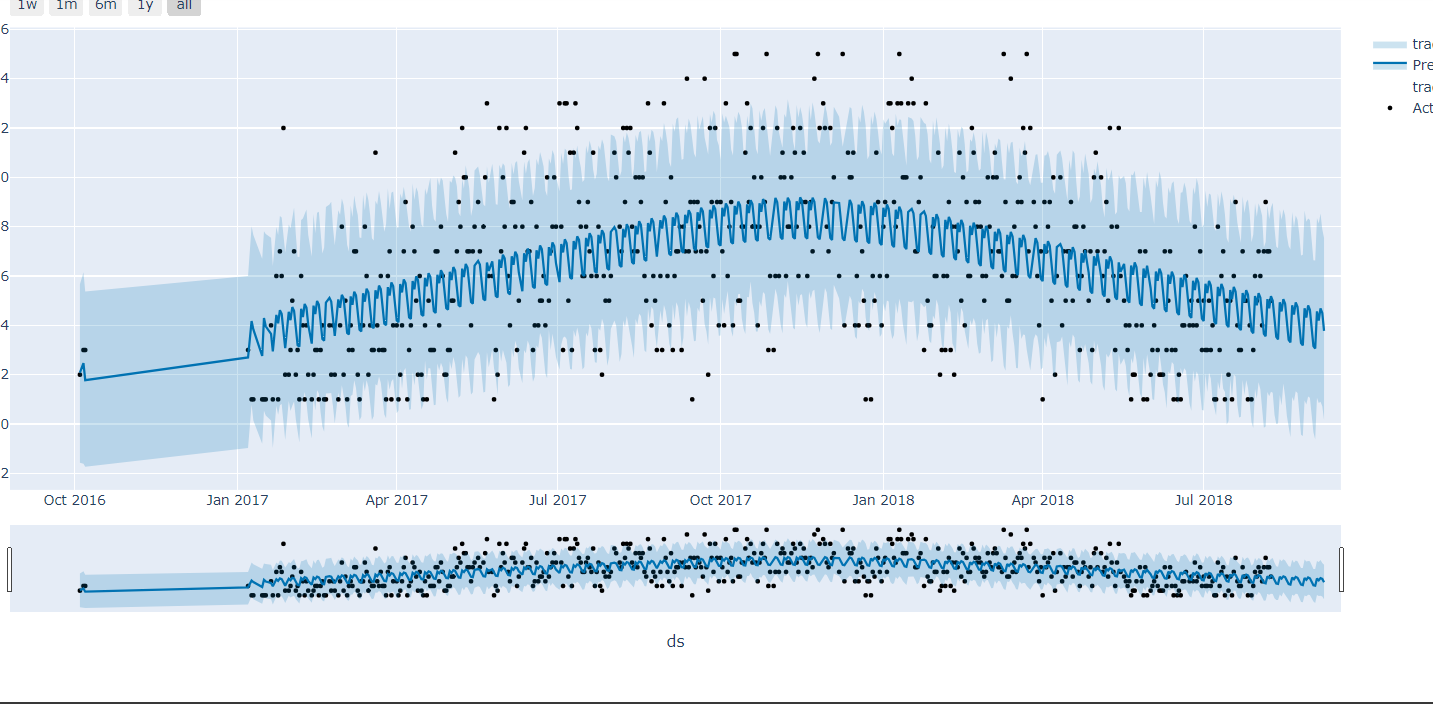

Both methods show good accuracy in short time , and what model chose - it depends on business task and data. In our case we will chose prophet model, as it  predicts data with better accuracy, it knows when weekends or holydays, that's very cruical for example before Christmas time and we can improve it much and can make it more complex in future. Arima can show trand, but it doesent know where is can be holydays or weekends...


According to the research data, a baseline of models was created that are close to each other in terms of accuracy. all further improvements will depend on the tasks provided by the departments that need this data. They can be used to optimize logistics, product downtime in warehouses, and possibly to reconsider the area of the required warehouse to reduce rent.

ARIMA

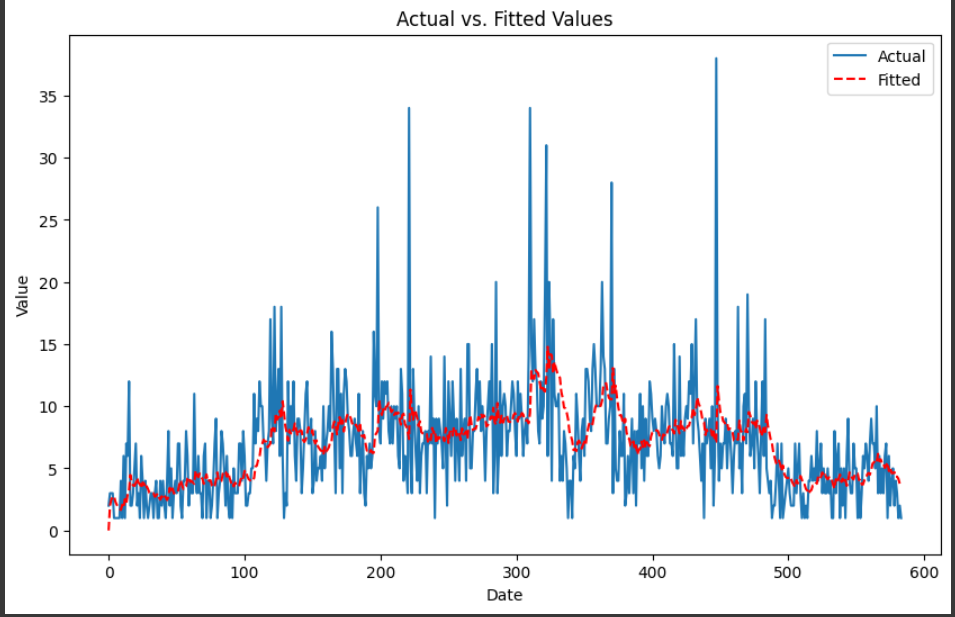